In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pathlib
import joblib
from lb2jpsil import lorentz

In [2]:
## Self explanatory
save_plots = True

## Toggle plot titles (off for thesis and papers, generally speaking)
show_titles = True

## Toggle plot grid
show_grid = False

## Black and white?
black_and_white = True

## Drop event if DTF_FixJPsiLambda failed?
dtf_success = True

## Veto physical background
b0_veto = True

## Select signal region ([5508.5, 5731.8] MeV/c^2)
only_sig_region = True

In [3]:
saved_models = {
    ## BALANCE
    ## Higher overtraining. Slightly better performance in test (fractions of percentage)
    'sachiel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'balance',
        'learning_rate' : 0.010,
        'max_leaf_nodes' : 200,
        'max_iter' : 5000,
        'soft_threshold': 0.7,
        'hard_threshold': 0.9924
    },
    ## Lower ovetraining. Looks better under K-S test. Slightly worse performance in test (fractions of percentage)
    'shamshel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'balance',
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 2500,
        'soft_threshold': 0.7,
        'hard_threshold': 0.985
    },
    ## BKGSKEW
    ## From an overtraining standpoint, this is the better one of the bkgskew
    'ramiel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 1500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.656
    },
    ## This has quite more overtraining, but loses less signal
    'israfel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.015,
        'max_leaf_nodes' : 100,
        'max_iter' : 1500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.714
    },
    ## Salvatore's HBDT, for performance comparison.
    ## Somewhat similar to israfel, does not match his original HBDT
    'sandalphon': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.01,
        'max_leaf_nodes' : 100,
        'max_iter' : 2500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.637
    }
}

In [4]:
## Either one of the names in list(saved_models) or 'temp' for custom new model
model_to_use = 'shamshel'

if model_to_use in saved_models:
    daughter_momenta = saved_models[model_to_use]['daughter_momenta']
    dataset_type = saved_models[model_to_use]['dataset_type']
    training_params = {key: saved_models[model_to_use][key] for key in ['learning_rate', 'max_leaf_nodes', 'max_iter']}
    hard_threshold = saved_models[model_to_use]['hard_threshold']
elif model_to_use == 'temp':
    ## Proton and pion momenta
    ## 'VF': use VF momenta
    ## 'DTF': use DTF momenta w/ JPsi m.c.
    ## 'DTFL': use DTF momenta w/ JPsi and Lambda m.c.
    ## 'NO': don't use any momenta for Lambda daughter particles
    daughter_momenta = 'DTF'

    ## Two options:
    ## 'balance': same number of training events for signal and bkg
    ## 'bkgskew' uses 4 mln events of bkg, 500k of signal
    dataset_type = 'bkgskew'

    training_params = {
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 5000
    }
    
    hard_threshold = 0.9
else:
    raise ValueError

In [5]:
if dataset_type not in ['balance', 'bkgskew']:
    raise ValueError

In [6]:
if daughter_momenta == 'VF':
    p_momenta = ['p_PT', 'p_PZ']
    pim_momenta = ['pim_PT', 'pim_PZ']
elif daughter_momenta == 'DTF':
    p_momenta = ['DTF_FixJPsi_p_PT', 'DTF_FixJPsi_p_PZ']
    pim_momenta = ['DTF_FixJPsi_pim_PT', 'DTF_FixJPsi_pim_PZ']
elif daughter_momenta == 'DTFL':
    p_momenta = ['DTF_FixJPsiLambda_p_PT', 'DTF_FixJPsiLambda_p_PZ']
    pim_momenta = ['DTF_FixJPsiLambda_pim_PT', 'DTF_FixJPsiLambda_pim_PZ']
elif daughter_momenta == 'NO':
    p_momenta = []
    pim_momenta = []
else:
    raise ValueError(daughter_momenta + " is not a valid option for momenta usage.")

In [7]:
if dataset_type == 'balance':
    dataset_suffix = 'BAL'
else:
    dataset_suffix = 'SKEW'

classifier_dump_filename = (
    'HBDT_'
    + daughter_momenta
    + '_' + str(training_params['learning_rate'])
    + '_' + str(training_params['max_leaf_nodes'])
    + '_' + str(training_params['max_iter'])
    + '_' + dataset_suffix
)

classifier_dump_filename

'HBDT_DTF_0.003_100_2500_BAL'

In [8]:
## Create plots directory, if missing
repo_directory = str(pathlib.Path.home()) + '/lambda-emdm-measurement/'
state_directory = str(pathlib.Path.home()) + '/classifier-studies/' + '20_HBDT/' + 'saved_states/'

plot_directory = (
    repo_directory + 'plots/'
    + 'angular_distribution_study/'
)

pathlib.Path(plot_directory).mkdir(parents=True, exist_ok=True)

In [9]:
path_to_hd5_files = str(pathlib.Path.home()) + '/data/'
input_mc = path_to_hd5_files + 'LHCbMC_2016-2017-2018_MagUpDown_Lb2JPsiL_Ttracks_v12.h5'
input_data = path_to_hd5_files + 'LHCbData_2016-2017-2018_MagUpDown_Dimuon_Ttracks_v2.h5'

# Data prepping
## Import Monte Carlo data

In [10]:
def p_modulus(px, py, pz):
    return np.sqrt(px**2 + py**2 + pz**2)

def transverse_p_modulus(px, py):
    return np.sqrt(px**2 + py**2)

In [11]:
df_reco = pd.read_hdf(input_mc, key='LHCbMC_Lb')
df_truth = pd.read_hdf(input_mc, key='LHCbMCTruth_Lb')
df_mc = pd.merge(df_truth.loc[df_truth['Rec_key'] >= 0], df_reco, left_index=True, right_on='MC_key')
df_mc = df_mc.loc[(df_mc['MC_key'] >= 0) & (df_mc['Rec_key'] >= 0)]

#del(df_reco, df_truth)
del(df_reco)

In [12]:
jpsi_pdg_mass = 3096.900
b0_pdg_mass = 5279.61
b0_veto_threshold = 70

In [13]:
## Missing "combined" invariant masses (for Lambda->p pim and Lambdab->JPsi Lambda)
## These are the AM in the DaVinci config file. Did Salvatore implement them somewhere?

pion_p_cuts = (
    (p_modulus(df_mc['pim_PX'], df_mc['pim_PY'], df_mc['pim_PZ']) > 2000)
    & (p_modulus(df_mc['pim_PX'], df_mc['pim_PY'], df_mc['pim_PZ']) < 5e5)
)

proton_p_cuts = (
    (p_modulus(df_mc['p_PX'], df_mc['p_PY'], df_mc['p_PZ']) > 10000)
    & (p_modulus(df_mc['p_PX'], df_mc['p_PY'], df_mc['p_PZ']) < 5e5)
)

proton_pt_cuts = transverse_p_modulus(df_mc['p_PX'], df_mc['p_PY']) > 400

lambda_m_cuts = (df_mc['L_M'] > 600) & (df_mc['L_M'] < 1500)
lambda_mm_cuts = df_mc['L_MM'] < 1500
lambda_z_cuts = (df_mc['L_ENDVERTEX_Z'] > 5500) & (df_mc['L_ENDVERTEX_Z'] < 8500)
lambda_dira_cuts = df_mc['L_BPVDIRA'] > 0.9999
lambda_ipchi2_cuts = df_mc['L_BPVIPCHI2'] < 200
lambda_vdchi2_cuts = df_mc['L_BPVVDCHI2'] < 2e7
lambda_chi2_cuts = df_mc['L_VFASPF_CHI2_VDOF'] < 750
lambda_pt_cuts = transverse_p_modulus(df_mc['L_PX'], df_mc['L_PY']) > 450

jpsi_m_cuts = abs(df_mc['Jpsi_M'] - jpsi_pdg_mass) < 90

lambdab_m_cuts = df_mc['Lb_M'] < 8500
lambdab_dira_cuts = abs(df_mc['Lb_BPVDIRA']) > 0.99
lambdab_ipchi2_cuts = df_mc['Lb_BPVIPCHI2'] < 1750
lambdab_chi2_cuts = df_mc['Lb_VFASPF_CHI2_VDOF'] < 150

dtf_success_cuts = df_mc['DTF_FixJPsiLambda_status'] == 'Success'

b0_veto_cuts = (df_mc['DTF_FixJPsiLambda_PIDSubs_status'] != 'Success') | (np.abs(df_mc['DTF_FixJPsiLambda_PIDSubs_Lb_M'] - b0_pdg_mass) > b0_veto_threshold)

In [14]:
pre_selection_cuts = (
    pion_p_cuts &
    proton_p_cuts &
    proton_pt_cuts &
    lambda_m_cuts &
    lambda_mm_cuts &
    lambda_z_cuts &
    lambda_dira_cuts &
    lambda_ipchi2_cuts &
    lambda_vdchi2_cuts &
    lambda_chi2_cuts &
    lambda_pt_cuts &
    jpsi_m_cuts &
    lambdab_m_cuts &
    lambdab_dira_cuts &
    lambdab_ipchi2_cuts &
    lambdab_chi2_cuts
)

if dtf_success:
    pre_selection_cuts = pre_selection_cuts & dtf_success_cuts
    
if b0_veto:
    pre_selection_cuts = pre_selection_cuts & b0_veto_cuts

#df_mc[pre_selection_cuts]

## Import Run 2 data

In [15]:
df_data = pd.read_hdf(input_data, key='LHCbData')

In [16]:
data_dtf_cuts = df_data['DTF_FixJPsiLambda_status'] == 'Success'
data_b0_veto_cuts = (df_data['DTF_FixJPsiLambda_PIDSubs_status'] != 'Success') | (np.abs(df_data['DTF_FixJPsiLambda_PIDSubs_Lb_M'] - b0_pdg_mass) > b0_veto_threshold)

In [17]:
data_cuts = pd.Series(True, index=df_data.index)

if dtf_success:
    data_cuts = data_cuts & data_dtf_cuts

if b0_veto:
    data_cuts = data_cuts & data_b0_veto_cuts

#df_data[data_cuts]

## Add derived variables

In [18]:
def add_derived_variables(
    df: pd.DataFrame
) -> None:
    df['p_PT'] = transverse_p_modulus(df['p_PX'], df['p_PY'])
    df['DTF_FixJPsi_p_PT'] = transverse_p_modulus(df['DTF_FixJPsi_p_PX'], df['DTF_FixJPsi_p_PY'])
    df['DTF_FixJPsiLambda_p_PT'] = transverse_p_modulus(df['DTF_FixJPsiLambda_p_PX'], df['DTF_FixJPsiLambda_p_PY'])
    df['pim_PT'] = transverse_p_modulus(df['pim_PX'], df['pim_PY'])
    df['DTF_FixJPsi_pim_PT'] = transverse_p_modulus(df['DTF_FixJPsi_pim_PX'], df['DTF_FixJPsi_pim_PY'])
    df['DTF_FixJPsiLambda_pim_PT'] = transverse_p_modulus(df['DTF_FixJPsiLambda_pim_PX'], df['DTF_FixJPsiLambda_pim_PY'])
    df['Jpsi_PT'] = transverse_p_modulus(df['Jpsi_PX'], df['Jpsi_PY'])
    
    dtf_success_mapper = {
        'Success': 0.0,
        'Failed': 1.0,
        'NonConverged': 3.0
    }

    df.replace({'DTF_FixJPsi_status': dtf_success_mapper}, inplace=True)
    df.replace({'DTF_FixJPsiLambda_status': dtf_success_mapper}, inplace=True)

In [19]:
add_derived_variables(df_mc)
add_derived_variables(df_data)

## Drop events not passing the prefilter

In [20]:
df_mc.drop(df_mc[~pre_selection_cuts].index, inplace=True)
df_data.drop(df_data[~data_cuts].index, inplace=True)

## Score HBDT and keep events above hard threshold

In [21]:
saved_state_file = state_directory + classifier_dump_filename + '.joblib'
HBDT = joblib.load(saved_state_file)

In [22]:
fixed_features = [
    'Jpsi_PT',
    'Jpsi_PZ',
    'L_ENDVERTEX_X',
    'L_ENDVERTEX_Y',
    'L_ENDVERTEX_Z',
    'L_BPVDIRA',
    'Lb_BPVDIRA',
    'L_VFASPF_CHI2_VDOF',
    'Lb_VFASPF_CHI2_VDOF',
    'L_BPVIPCHI2',
    'Lb_BPVIPCHI2',
    'L_BPVVDCHI2',
    'Lb_BPVVDCHI2',
    'DTF_FixJPsi_status',
    'DTF_FixJPsiLambda_status'
]

features = p_momenta + pim_momenta + fixed_features

In [23]:
mc_predicted = HBDT.predict_proba(df_mc.loc[:, features].to_numpy())[:,1]
df_mc['HBDT'] = mc_predicted
mc_pass_threshold = df_mc['HBDT'] > hard_threshold

In [24]:
data_predicted = HBDT.predict_proba(df_data.loc[:, features].to_numpy())[:,1]
df_data['HBDT'] = data_predicted
data_pass_threshold = df_data['HBDT'] > hard_threshold
data_pass_hard_bkg_threshold = df_data['HBDT'] < 0.001

In [25]:
df_mc.drop(df_mc[~mc_pass_threshold].index, inplace=True)
df_deep_background = df_data[data_pass_hard_bkg_threshold].copy()
df_data.drop(df_data[~data_pass_threshold].index, inplace=True)

del(mc_predicted, data_predicted)

One last thing: excise events outside of the desired invariant mass window.

In [26]:
if only_sig_region:
    lower_limit_mass = 5508.5
    upper_limit_mass = 5731.8
else:
    lower_limit_mass = 5000
    upper_limit_mass = 6200

mc_Lb_invmass_cut = ((df_mc['DTF_FixJPsiLambda_Lb_M'] > lower_limit_mass) & (df_mc['DTF_FixJPsiLambda_Lb_M'] < upper_limit_mass))
data_Lb_invmass_cut = ((df_data['DTF_FixJPsiLambda_Lb_M'] > lower_limit_mass) & (df_data['DTF_FixJPsiLambda_Lb_M'] < upper_limit_mass))
bkg_Lb_invmass_cut = ((df_deep_background['DTF_FixJPsiLambda_Lb_M'] > 4000) & (df_deep_background['DTF_FixJPsiLambda_Lb_M'] < 7000))

In [27]:
df_mc.drop(df_mc[~mc_Lb_invmass_cut].index, inplace=True)
df_data.drop(df_data[~data_Lb_invmass_cut].index, inplace=True)
df_deep_background.drop(df_deep_background[~bkg_Lb_invmass_cut].index, inplace=True)

In [28]:
df_mc

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,TrackType_y,MC_key,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,HBDT
Rec_key,,,,,,,,,,,,,,,,,,,,,
14,0.9904,-0.2075,-9.769600,224.561996,56.081600,5921.048828,2894.560059,699.140015,74302.851562,293.929993,...,T,367,3138.222168,2606.361572,2835.955811,563.971436,397.024719,499.553711,1183.876953,0.993490
25,1.4204,0.1756,6.183100,113.135696,223.900299,7097.245117,1002.729980,2151.709961,69297.921875,246.179993,...,T,619,3129.654541,2471.828369,2450.595215,501.604156,426.218414,421.343781,3530.665527,0.995001
36,0.6354,-0.1720,-26.184099,83.245796,126.276802,7588.293457,520.130005,653.900024,45147.179688,61.330002,...,T,798,984.302063,885.361511,888.376526,262.376190,259.310089,252.252304,3836.018311,0.988892
56,1.0630,-0.1569,14.631200,-16.393600,-267.315704,7429.070312,19.139999,-1164.579956,32903.449219,-108.959999,...,T,1391,1677.147461,1222.470947,1180.346313,260.234802,254.823410,243.301285,2582.130859,0.986191
71,1.8416,-1.3280,21.833700,628.105896,-929.930481,7475.404785,3879.139893,-5898.799805,47200.421875,1059.250000,...,T,1897,5397.982422,6764.600098,6947.719238,1786.030396,1679.542480,1734.952637,6626.127441,0.997901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366241,1.7275,-0.3783,46.236500,115.471901,-139.676102,6949.710938,1319.449951,-1580.469971,82045.710938,185.220001,...,T,8918141,2041.361572,2035.740845,2055.870117,359.799988,291.229736,297.264832,8557.088867,0.996566
366267,1.4960,0.4462,-21.932100,171.948593,299.047791,7071.188477,1051.619995,1886.640015,46525.289062,303.820007,...,T,8918745,2245.093506,1952.591919,2039.183350,553.135132,510.911560,556.640259,4791.497559,0.993085
366268,0.9817,-0.2910,-13.832300,402.671509,16.624701,8214.584961,1634.530029,26.360001,33188.000000,113.620003,...,T,8918751,2154.688965,1975.448608,1626.364014,105.307137,119.006645,118.100471,2818.800293,0.986714


In [29]:
df_data

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,HBDT
1243,0.570611,-0.048790,9.819603,-219.870300,-23.170826,6890.049316,0.5706,-0.0484,9.826700,-2135.995850,...,43281.066406,T,2118.871582,2296.816406,2250.925537,25.952250,128.293900,133.510849,1713.736938,0.991741
14966,0.301274,0.002878,-81.769859,-496.445862,81.825195,6977.776855,0.3013,0.0029,-81.771896,-3502.455811,...,90013.523438,T,2957.904297,2722.864990,2763.008057,862.095093,727.754333,808.208496,3456.856445,0.995655
28004,1.020999,1.607981,63.884747,34.099216,534.048462,6518.728516,1.0211,1.6079,63.884602,552.369690,...,14888.348633,T,3609.034668,4370.840820,3929.881592,1530.654907,1329.929810,1164.037354,1783.447632,0.990346
34428,0.990594,-0.371041,-42.860867,337.635895,-248.060776,7536.824219,0.9905,-0.3711,-42.859402,2353.778076,...,20840.720703,T,2112.428223,2872.730957,2509.491211,719.300171,633.245483,565.653503,960.763733,0.993720
37728,0.795410,-0.045465,38.450478,-451.465973,338.912628,6704.439941,0.7954,-0.0455,38.450298,-1892.045654,...,15316.548828,T,2275.273926,2381.954834,2343.148193,105.937561,195.158646,200.321213,2073.057129,0.994386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43629679,0.667229,0.273313,12.532696,-91.095360,197.538239,5814.236328,0.6672,0.2733,12.533400,-1341.020630,...,73674.085938,T,2093.361816,2471.042969,2583.435303,771.628052,516.789368,580.826904,3230.198242,0.987454
43630161,1.022181,1.066146,70.497398,171.919266,231.435410,6406.840820,1.0221,1.0663,70.501900,1106.417236,...,52743.011719,T,1663.768433,2590.177734,2674.639160,508.990234,501.949463,509.227417,1676.356445,0.994948
43635933,0.334199,0.791410,59.569798,-473.846802,452.725983,7253.046875,0.3342,0.7914,59.570000,-5075.172852,...,9681.804688,T,6448.008301,4330.627441,4390.572754,752.062317,699.129333,686.459412,3125.482666,0.998032
43641335,1.592275,0.470475,40.528099,844.270691,408.556732,7128.458008,1.5923,0.4705,40.528198,8160.525879,...,22930.691406,T,7166.815430,5513.578125,5487.751465,1606.892700,1651.535400,1634.031738,2975.259766,0.997649


In [30]:
df_deep_background

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,HBDT
1920,0.274885,-0.867234,-22.956949,-86.150719,-117.302788,6148.786133,0.2737,-0.8651,-22.965401,-497.163666,...,55393.640625,T,999.873840,453.532318,434.891083,465.926086,363.937317,149.462357,574.942688,0.000998
2409,1.107588,-0.187793,-23.164124,33.708591,-32.367043,5610.781738,1.1074,-0.1873,-23.160801,442.633301,...,15064.434570,T,1007.530945,720.962158,96.116203,571.619019,540.173645,221.813416,1724.839600,0.000912
2661,0.610647,0.154283,-33.663177,71.250458,36.433697,6488.456055,0.6108,0.1551,-33.660000,696.338135,...,7814.743164,T,1076.663208,505.944885,277.276520,452.990173,254.594788,107.082443,1984.778931,0.000998
2744,0.998672,-0.041308,-45.186707,71.102882,-37.917423,6193.756348,0.9992,-0.0409,-45.202599,492.654999,...,56431.710938,T,917.759155,321.395264,229.834839,467.714966,131.330124,85.716179,3814.214844,0.000775
2806,-0.232989,-1.471701,-35.660137,74.183418,87.554176,6123.831055,-0.2259,-1.4626,-35.764301,512.325378,...,34106.535156,T,1173.831787,245.570938,131.278076,483.463867,452.099854,236.646179,790.779053,0.000816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43648183,1.237120,0.778792,4.660105,63.144844,-14.380929,5958.989258,1.2364,0.7754,4.678500,530.863342,...,52404.539062,T,1041.046265,484.981934,228.165588,506.074066,278.552032,57.001888,2289.234863,0.000846
43648398,0.217560,0.434204,-42.526089,45.963982,-33.921314,5729.029297,0.2179,0.4330,-42.518002,435.084961,...,5554.691406,T,1017.487610,405.852356,115.098091,577.305786,241.195251,39.180534,4234.730957,0.000908
43648583,0.680260,0.056221,17.320061,54.512447,7.496017,5811.333008,0.6854,0.0614,17.497801,497.473969,...,126377.351562,T,950.515808,314.855103,20.909595,511.525604,137.060196,162.381546,5405.449219,0.000801
43649017,1.326780,-0.580311,6.367840,58.659927,-45.951469,5870.125488,1.3271,-0.5803,6.367400,557.660522,...,6525.698242,T,1005.464478,415.202789,102.281487,248.764359,218.389572,132.826721,2030.629883,0.000861


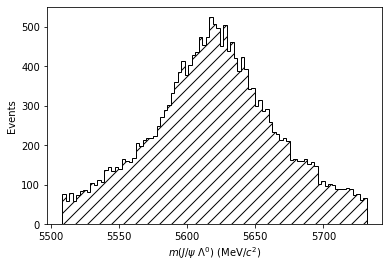

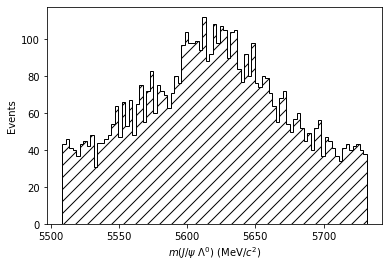

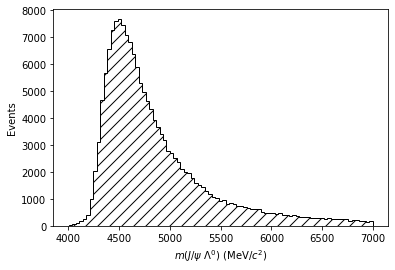

In [31]:
common_plot_params = {
    'bins': 87,
    'histtype': 'stepfilled',
    'facecolor': 'none',
    'edgecolor': 'black',
    'hatch': '//'
}

xlabel = "$m(J/\psi~\Lambda^0)$ (MeV/$c^2$)"
ylabel = 'Events'

plt.hist(df_mc['DTF_FixJPsiLambda_Lb_M'], **common_plot_params)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

plt.hist(df_data['DTF_FixJPsiLambda_Lb_M'], **common_plot_params)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

plt.hist(df_deep_background['DTF_FixJPsiLambda_Lb_M'], **common_plot_params)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

# Proton helicity angle

In [32]:
def calculate_at_rest_kine(
    df: pd.DataFrame,
    daughters: dict,
    suffix_start: str = None,
    suffix_end: str = 'Star'
):
    
    if suffix_start is not None:
        suffix_start = '_' + suffix_start
    else:
        suffix_start = ''
    
    daughters_p = {
        part_name: lorentz.four_vector_from_PXPYPZM(
            df[f'{part_name}_PX{suffix_start}'],
            df[f'{part_name}_PY{suffix_start}'],
            df[f'{part_name}_PZ{suffix_start}'],
            part_mass)
        for part_name, part_mass in daughters.items()
    }
    mother_p = sum(daughters_p.values())
    daughters_p_star = {
        part_name: lorentz.boost_from_mom(part_p, mother_p)
        for part_name, part_p in daughters_p.items()
    }
    for part_name, p_star in daughters_p_star.items():
        df[f'{part_name}_PX_{suffix_end}'] = p_star[0]
        df[f'{part_name}_PY_{suffix_end}'] = p_star[1]
        df[f'{part_name}_PZ_{suffix_end}'] = p_star[2]
        df[f'{part_name}_P_{suffix_end}'] = np.sqrt(p_star[0]**2 + p_star[1]**2 + p_star[2]**2)


def calculate_helicity_angle(
    df: pd.DataFrame,
    daughter: str,
    mother: str,
    daughter_suffix: str,
    mother_suffix: str,
    angle_suffix: str = None
):
    if angle_suffix is not None:
        angle_suffix = '_' + angle_suffix
    else:
        angle_suffix = ''
    
    daughter_p = np.array([
        df[f'{daughter}_PX_{daughter_suffix}'],
        df[f'{daughter}_PY_{daughter_suffix}'],
        df[f'{daughter}_PZ_{daughter_suffix}']])
    mother_p = np.array([
        df[f'{mother}_PX_{mother_suffix}'],
        df[f'{mother}_PY_{mother_suffix}'],
        df[f'{mother}_PZ_{mother_suffix}']])
    angle = lorentz.cos_angle(mother_p, daughter_p)
    df[f'{daughter}_Theta{angle_suffix}'] = angle

## What it does: computes momenta in Lambda frame and Lambdab frames
## Then computes angle between p(p) in Lambda frame and p(Lambda) in Lambdab frame 
def calculate_proton_lambda_helicity_angle(df, prefix):
    calculate_at_rest_kine(df, {
        f'{prefix}p' : 938.27208816,
        f'{prefix}pim' : 139.57018,
    }, suffix_end='LambdaFrame')
    calculate_at_rest_kine(df, {
        f'{prefix}p' : 938.27208816,
        f'{prefix}pim' : 139.57018,
        f'{prefix}mup' : 105.6583755,
        f'{prefix}mum' : 105.6583755,
    }, suffix_end='LambdabFrame')
    for coord in ['X', 'Y', 'Z']:
        df[f'{prefix}L_P{coord}_LambdabFrame'] = df[f'{prefix}p_P{coord}_LambdabFrame'] + df[f'{prefix}pim_P{coord}_LambdabFrame']
    calculate_helicity_angle(df, f'{prefix}p', f'{prefix}L',
                             daughter_suffix='LambdaFrame', mother_suffix='LambdabFrame')

## Same thing as above, but use LambdaFromLambdabFrame for the p frame. Instead of going lab->Lambda,
## we do lab->Lambdab->Lambda for the proton
def calculate_proton_lambda_helicity_angle_from_lambdab_frame(df, prefix):
    calculate_at_rest_kine(df, {
        f'{prefix}p' : 938.27208816,
        f'{prefix}pim' : 139.57018,
        f'{prefix}mup' : 105.6583755,
        f'{prefix}mum' : 105.6583755,
    }, suffix_end='LambdabFrame')

    for coord in ['X', 'Y', 'Z']:
        df[f'{prefix}L_P{coord}_LambdabFrame'] = df[f'{prefix}p_P{coord}_LambdabFrame'] + df[f'{prefix}pim_P{coord}_LambdabFrame']

    calculate_at_rest_kine(df, {
        f'{prefix}p' : 938.27208816,
        f'{prefix}pim' : 139.57018,
    }, suffix_start='LambdabFrame', suffix_end='LambdaFromLambdabFrame')
        
    calculate_helicity_angle(
        df, f'{prefix}p', f'{prefix}L',
        daughter_suffix='LambdaFromLambdabFrame', mother_suffix='LambdabFrame', angle_suffix='IFM')

## Simulation (all)

In [33]:
calculate_proton_lambda_helicity_angle(df_truth, 'MCTRUTH_')

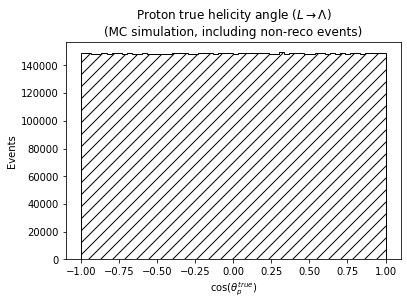

In [34]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//'
}

xlabel = r"$\cos(\theta_p^{true})$"
ylabel = "Events"
title = r"Proton true helicity angle ($L \rightarrow \Lambda$)" + "\n" + "(MC simulation, including non-reco events)"
file_name = 'MCTRUTH_helicity_angle_true'

plt.hist(df_truth['MCTRUTH_p_Theta'], **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()

In [35]:
calculate_proton_lambda_helicity_angle_from_lambdab_frame(df_truth, 'MCTRUTH_')

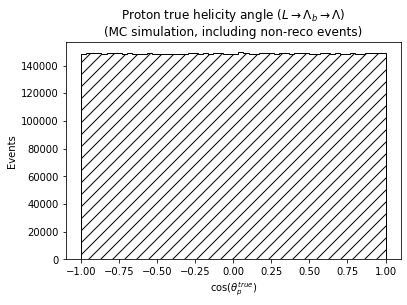

In [36]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//'
}

xlabel = r"$\cos(\theta_p^{true})$"
ylabel = "Events"
title = r"Proton true helicity angle ($L \rightarrow \Lambda_b \rightarrow \Lambda$)" + "\n" + "(MC simulation, including non-reco events)"
file_name = 'MC_helicity_angle_true_IFM'

plt.hist(df_truth['MCTRUTH_p_Theta_IFM'], **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()

## Simulation (reconstructed)

In [37]:
calculate_proton_lambda_helicity_angle(df_mc, 'DTF_FixJPsiLambda_')
calculate_proton_lambda_helicity_angle(df_mc, 'MCTRUTH_')

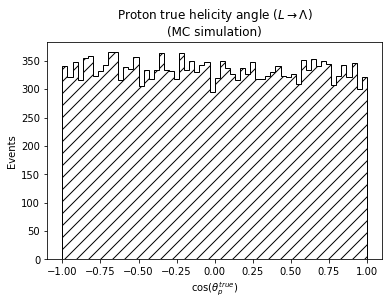

In [38]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//'
}

xlabel = r"$\cos(\theta_p^{true})$"
ylabel = "Events"
title = r"Proton true helicity angle ($L \rightarrow \Lambda$)" + "\n" + "(MC simulation)"
file_name = 'MC_helicity_angle_true'

plt.hist(df_mc['MCTRUTH_p_Theta'], **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()

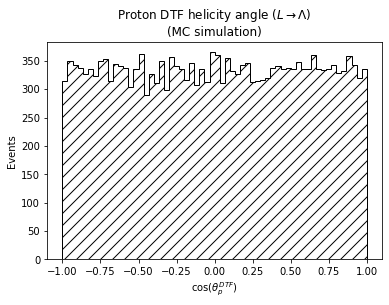

In [39]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//'
}

xlabel = r"$\cos(\theta_p^{DTF})$"
ylabel = "Events"
title = r"Proton DTF helicity angle ($L \rightarrow \Lambda$)" + "\n" + "(MC simulation)"
file_name = 'MC_helicity_angle_reco'

plt.hist(df_mc['DTF_FixJPsiLambda_p_Theta'], **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()

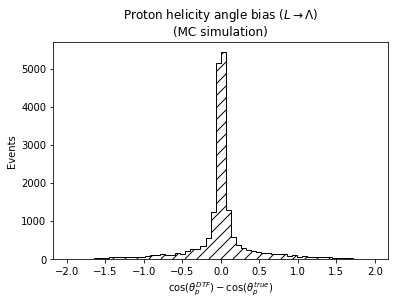

In [40]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//'
}

xlabel = r"$\cos(\theta_p^{DTF}) - \cos(\theta_p^{true})$"
ylabel = "Events"
title = r"Proton helicity angle bias ($L \rightarrow \Lambda$)" + "\n" + "(MC simulation)"
file_name = 'MC_helicity_angle_bias'

plt.hist(
    df_mc['DTF_FixJPsiLambda_p_Theta'] - df_mc['MCTRUTH_p_Theta'],
    **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()

In [41]:
helicity_edges = np.linspace(-1,1,9)
helicity_bins = [(l,r) for l, r in zip(helicity_edges[:-1], helicity_edges[1:])] 

In [42]:
migration_matrix = []

for bin_true in helicity_bins:
    bin_true_selection = (
        (df_mc['MCTRUTH_p_Theta'] >= bin_true[0])
        & (df_mc['MCTRUTH_p_Theta'] < bin_true[1])
    )
    events_in_bin_true = sum(bin_true_selection)
    row = []
    for bin_reco in helicity_bins:
        bin_reco_selection = (
            bin_true_selection
            & (df_mc['DTF_FixJPsiLambda_p_Theta'] >= bin_reco[0])
            & (df_mc['DTF_FixJPsiLambda_p_Theta'] < bin_reco[1])
        )
        events_in_bin_reco_and_bin_true = sum(bin_reco_selection)
        row.append(events_in_bin_reco_and_bin_true/events_in_bin_true)
        
    migration_matrix.insert(0, row)
    
migration_matrix = np.array(migration_matrix)

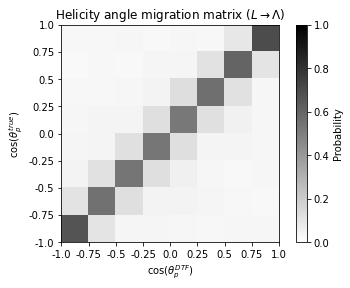

In [43]:
#plt.figure()
fig, ax = plt.subplots()

plt.imshow(migration_matrix, cmap='binary', vmin=0, vmax=1)

plt.colorbar(label='Probability')
ax.xaxis.set(ticks=np.arange(-0.5, len(helicity_edges)-1), ticklabels=helicity_edges)
ax.yaxis.set(ticks=np.arange(-0.5, len(helicity_edges)-1), ticklabels=helicity_edges[::-1])
plt.xlabel(r'$\cos(\theta_p^{DTF})$')
plt.ylabel(r'$\cos(\theta_p^{true})$')

if show_titles:
    plt.title(r"Helicity angle migration matrix ($L \rightarrow \Lambda$)")

if save_plots:
    plt.savefig(plot_directory + 'helicity_migration_matrix' + '.pdf', bbox_inches = 'tight')

plt.show()

In [44]:
calculate_proton_lambda_helicity_angle_from_lambdab_frame(df_mc, 'DTF_FixJPsiLambda_')
calculate_proton_lambda_helicity_angle_from_lambdab_frame(df_mc, 'MCTRUTH_')

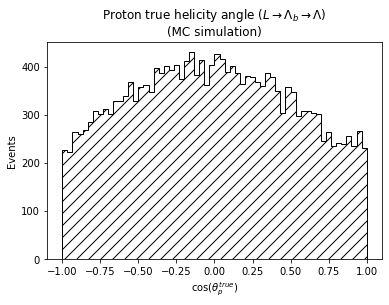

In [45]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//'
}

xlabel = r"$\cos(\theta_p^{true})$"
ylabel = "Events"
title = r"Proton true helicity angle ($L \rightarrow \Lambda_b \rightarrow \Lambda$)" + "\n" + "(MC simulation)"
file_name = 'MC_helicity_angle_true_IFM'

plt.hist(df_mc['MCTRUTH_p_Theta_IFM'], **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()

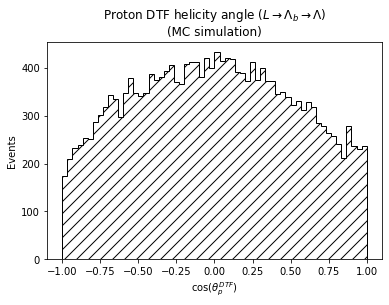

In [46]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//'
}

xlabel = r"$\cos(\theta_p^{DTF})$"
ylabel = "Events"
title = r"Proton DTF helicity angle ($L \rightarrow \Lambda_b \rightarrow \Lambda$)" + "\n" + "(MC simulation)"
file_name = 'MC_helicity_angle_reco_IFM'

plt.hist(df_mc['DTF_FixJPsiLambda_p_Theta_IFM'], **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()

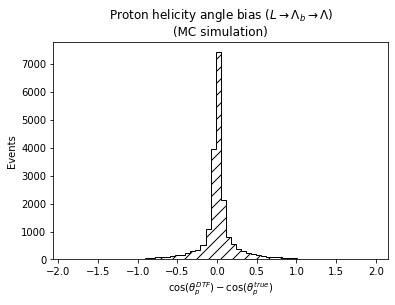

In [47]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//'
}

xlabel = r"$\cos(\theta_p^{DTF}) - \cos(\theta_p^{true})$"
ylabel = "Events"
title = r"Proton helicity angle bias ($L \rightarrow \Lambda_b \rightarrow \Lambda$)" + "\n" + "(MC simulation)"
file_name = 'MC_helicity_angle_bias_IFM'

plt.hist(
    df_mc['DTF_FixJPsiLambda_p_Theta_IFM'] - df_mc['MCTRUTH_p_Theta_IFM'],
    **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()

## Run 2 data

In [48]:
calculate_proton_lambda_helicity_angle(df_data, 'DTF_FixJPsiLambda_')

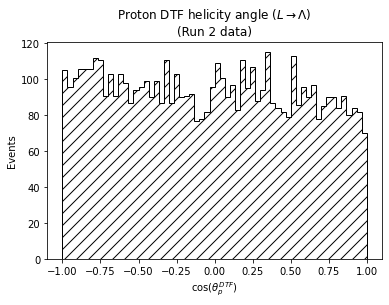

In [49]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//',
}

xlabel = r"$\cos(\theta_p^{DTF})$"
ylabel = "Events"
title = r"Proton DTF helicity angle ($L \rightarrow \Lambda$)" + "\n" + "(Run 2 data)"
file_name = 'Data_helicity_angle_reco'

plt.hist(df_data['DTF_FixJPsiLambda_p_Theta'], **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()

In [50]:
calculate_proton_lambda_helicity_angle_from_lambdab_frame(df_data, 'DTF_FixJPsiLambda_')

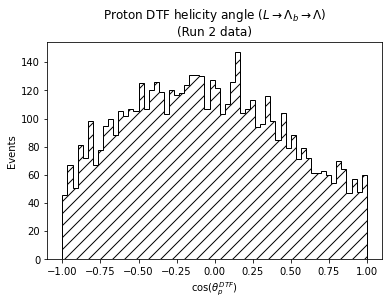

In [51]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//',
}

xlabel = r"$\cos(\theta_p^{DTF})$"
ylabel = "Events"
title = r"Proton DTF helicity angle ($L \rightarrow \Lambda_b \rightarrow \Lambda$)" + "\n" + "(Run 2 data)"
file_name = 'Data_helicity_angle_reco_IFM'

plt.hist(df_data['DTF_FixJPsiLambda_p_Theta_IFM'], **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()

### Comparison with deep background

In [52]:
calculate_proton_lambda_helicity_angle(df_deep_background, 'DTF_FixJPsiLambda_')

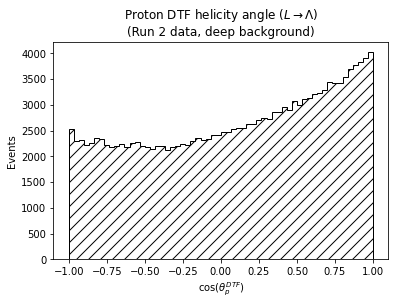

In [53]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//',
}

xlabel = r"$\cos(\theta_p^{DTF})$"
ylabel = "Events"
title = r"Proton DTF helicity angle ($L \rightarrow \Lambda$)" + "\n" + "(Run 2 data, deep background)"
file_name = 'Bkg_helicity_angle_reco'

plt.hist(df_deep_background['DTF_FixJPsiLambda_p_Theta'], **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()

In [54]:
calculate_proton_lambda_helicity_angle_from_lambdab_frame(df_deep_background, 'DTF_FixJPsiLambda_')

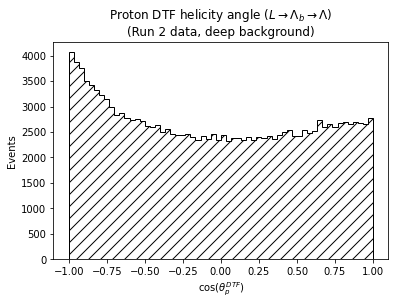

In [55]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//',
}

xlabel = r"$\cos(\theta_p^{DTF})$"
ylabel = "Events"
title = r"Proton DTF helicity angle ($L \rightarrow \Lambda_b \rightarrow \Lambda$)" + "\n" + "(Run 2 data, deep background)"
file_name = 'Bkg_helicity_angle_reco_IFM'

plt.hist(df_deep_background['DTF_FixJPsiLambda_p_Theta_IFM'], **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()